<a href="https://colab.research.google.com/github/AllenHuang03/104947567_concept2/blob/Classification-Models/Hybrid_training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Load datasets
df = pd.read_csv('/content/drive/My Drive/UNSW_NB15_testing-set.csv')


In [19]:
# Hybrid Model 1: RandomForest + GradientBoosting
class HybridRFGB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100):
        self.rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        self.gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

    def fit(self, X, y):
        self.rf.fit(X, y)
        self.gb.fit(X, y)
        return self

    def predict(self, X):
        rf_pred = self.rf.predict_proba(X)
        gb_pred = self.gb.predict_proba(X)
        return np.argmax((rf_pred + gb_pred) / 2, axis=1)

In [20]:
# Hybrid Model 2: XGBoost + LightGBM
class HybridXGBLGB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100):
        self.xgb = xgb.XGBClassifier(n_estimators=n_estimators, random_state=42)
        self.lgb = lgb.LGBMClassifier(n_estimators=n_estimators, random_state=42)

    def fit(self, X, y):
        self.xgb.fit(X, y)
        self.lgb.fit(X, y)
        return self

    def predict(self, X):
        xgb_pred = self.xgb.predict_proba(X)
        lgb_pred = self.lgb.predict_proba(X)
        return np.argmax((xgb_pred + lgb_pred) / 2, axis=1)

In [21]:
# Hybrid Model 3: SVM + Neural Network
class HybridSVMNN(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.svm = SVC(probability=True, random_state=42)
        self.nn = MLPClassifier(random_state=42)

    def fit(self, X, y):
        self.svm.fit(X, y)
        self.nn.fit(X, y)
        return self

    def predict(self, X):
        svm_pred = self.svm.predict_proba(X)
        nn_pred = self.nn.predict_proba(X)
        return np.argmax((svm_pred + nn_pred) / 2, axis=1)

In [22]:
# Feature selection
def select_features(X, y, k=19):
    selector = SelectKBest(mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return X_selected, selected_features

In [23]:
# Preprocess the data
def preprocess_data(df):
    # Drop the 'id' column
    df = df.drop('id', axis=1)

    # Separate features and targets
    X = df.drop(['attack_cat', 'label'], axis=1)
    y_binary = df['label']
    y_multiclass = df['attack_cat']

    # Handle categorical variables
    categorical_cols = ['proto', 'service', 'state']
    X = pd.get_dummies(X, columns=categorical_cols)

    # Label encode the targets
    le_binary = LabelEncoder()
    le_multiclass = LabelEncoder()
    y_binary = le_binary.fit_transform(y_binary)
    y_multiclass = le_multiclass.fit_transform(y_multiclass)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Perform feature selection
    X_selected, selected_features = select_features(X_scaled, y_binary, k=19)

    # Create new dataframes with selected features
    X_selected = pd.DataFrame(X_selected, columns=selected_features)

    # Split the selected features data
    X_train, X_temp, y_binary_train, y_binary_temp, y_multi_train, y_multi_temp = train_test_split(
        X_selected, y_binary, y_multiclass, test_size=0.3, random_state=42)

    X_val, X_test, y_binary_val, y_binary_test, y_multi_val, y_multi_test = train_test_split(
        X_temp, y_binary_temp, y_multi_temp, test_size=0.5, random_state=42)

    return (X_train, X_val, X_test,
            y_binary_train, y_binary_val, y_binary_test,
            y_multi_train, y_multi_val, y_multi_test,
            le_binary, le_multiclass, selected_features)



In [24]:
# Train and evaluate model
def train_evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Validation predictions shape: {y_val_pred.shape}")
    print(f"{model_name} - Test predictions shape: {y_test_pred.shape}")

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"{model_name} Results:")
    print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")
    print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

    return model, y_test_pred

In [25]:
# Visualize results
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [26]:

import joblib
import os
# Save the hybrid model
def save_hybrid_model(model, selected_features, le, save_path):
    os.makedirs(save_path, exist_ok=True)

    # Save the RandomForest and GradientBoosting components
    joblib.dump(model.rf, f"{save_path}/random_forest_model.joblib")
    joblib.dump(model.gb, f"{save_path}/gradient_boosting_model.joblib")

    # Save the selected features and label encoder
    joblib.dump(selected_features, f"{save_path}/selected_features.joblib")
    joblib.dump(le, f"{save_path}/label_encoder.joblib")

    print(f"Model components saved to {save_path}")

Selected Features: ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_state_ttl', 'ct_dst_sport_ltm', 'state_INT']
Binary Classification
Hybrid RandomForest + GradientBoosting - Validation predictions shape: (12350,)
Hybrid RandomForest + GradientBoosting - Test predictions shape: (12350,)
Hybrid RandomForest + GradientBoosting Results:
Validation - Accuracy: 0.9355, Precision: 0.9366, Recall: 0.9355, F1-score: 0.9357
Test - Accuracy: 0.9367, Precision: 0.9377, Recall: 0.9367, F1-score: 0.9368



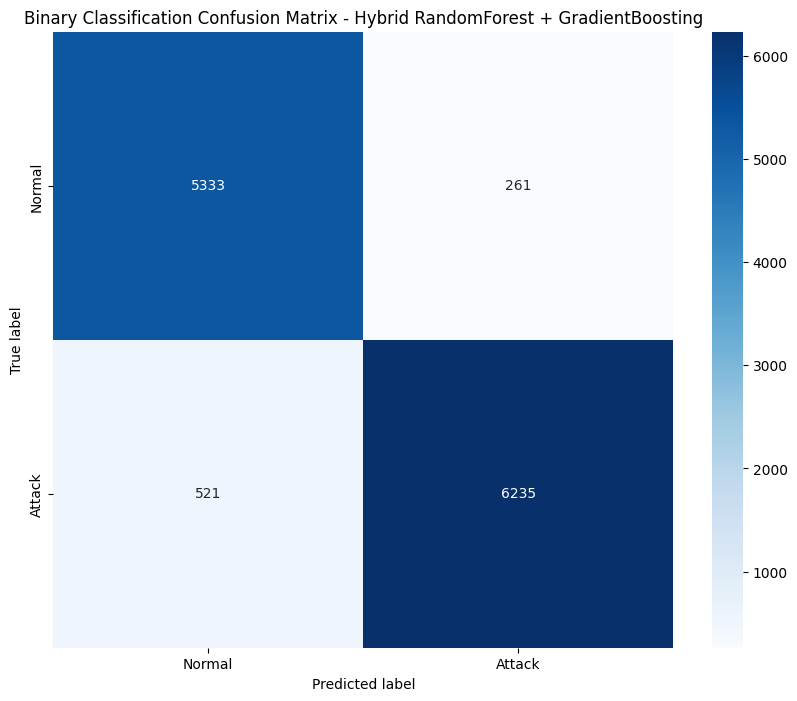

Multi-class Classification
Hybrid RandomForest + GradientBoosting - Validation predictions shape: (12350,)
Hybrid RandomForest + GradientBoosting - Test predictions shape: (12350,)
Hybrid RandomForest + GradientBoosting Results:
Validation - Accuracy: 0.8413, Precision: 0.8223, Recall: 0.8413, F1-score: 0.8265
Test - Accuracy: 0.8423, Precision: 0.8271, Recall: 0.8423, F1-score: 0.8294



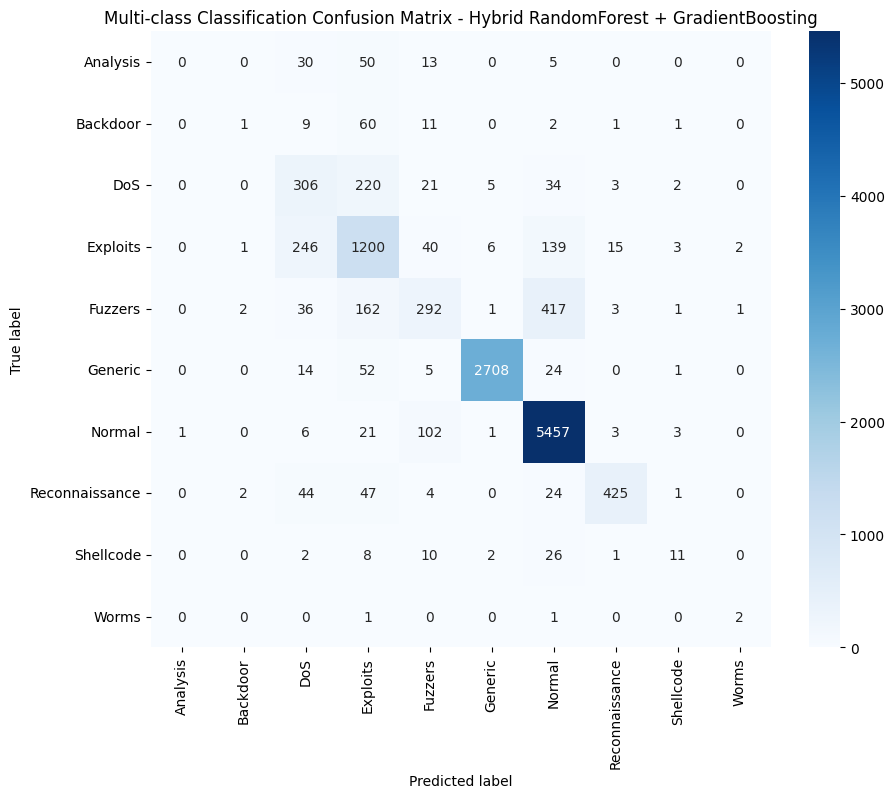

Best Binary Model - Validation predictions shape: (12350,)
Best Binary Model - Test predictions shape: (12350,)
Best Binary Model Results:
Validation - Accuracy: 0.9355, Precision: 0.9366, Recall: 0.9355, F1-score: 0.9357
Test - Accuracy: 0.9367, Precision: 0.9377, Recall: 0.9367, F1-score: 0.9368

Best Multiclass Model - Validation predictions shape: (12350,)
Best Multiclass Model - Test predictions shape: (12350,)
Best Multiclass Model Results:
Validation - Accuracy: 0.8413, Precision: 0.8223, Recall: 0.8413, F1-score: 0.8265
Test - Accuracy: 0.8423, Precision: 0.8271, Recall: 0.8423, F1-score: 0.8294

Model components saved to /content/saved_model_binary
Model components saved to /content/saved_model_multiclass
Best models have been saved.
updating: content/saved_model_binary/ (stored 0%)
updating: content/saved_model_binary/random_forest_model.joblib (deflated 82%)
updating: content/saved_model_binary/scaler.joblib (deflated 54%)
updating: content/saved_model_binary/label_encoder.j

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Main execution
if __name__ == "__main__":
    # Load dataset from Google Drive
    df = pd.read_csv('/content/drive/My Drive/UNSW_NB15_testing-set.csv')
 # Preprocess the data
    X_train, X_val, X_test, y_binary_train, y_binary_val, y_binary_test, \
    y_multi_train, y_multi_val, y_multi_test, le_binary, le_multiclass, selected_features = preprocess_data(df)

    print("Selected Features:", selected_features)

     # Binary Classification
    print("Binary Classification")
    hybrid_models = [
        (HybridRFGB(), "Hybrid RandomForest + GradientBoosting")
    ]

    for model, name in hybrid_models:
        _, y_pred_binary = train_evaluate_model(X_train, X_val, X_test,
                                                y_binary_train, y_binary_val, y_binary_test, model, name)
        plot_confusion_matrix(y_binary_test, y_pred_binary, classes=['Normal', 'Attack'],
                              title=f'Binary Classification Confusion Matrix - {name}')

    # Multi-class Classification
    print("Multi-class Classification")
    for model, name in hybrid_models:
        _, y_pred_multi = train_evaluate_model(X_train, X_val, X_test,
                                               y_multi_train, y_multi_val, y_multi_test, model, name)
        plot_confusion_matrix(y_multi_test, y_pred_multi, classes=le_multiclass.classes_,
                              title=f'Multi-class Classification Confusion Matrix - {name}')

    # Train and save the best models
    best_binary_model, _ = train_evaluate_model(X_train, X_val, X_test,
                                                y_binary_train, y_binary_val, y_binary_test,
                                                HybridRFGB(), "Best Binary Model")
    best_multi_model, _ = train_evaluate_model(X_train, X_val, X_test,
                                               y_multi_train, y_multi_val, y_multi_test,
                                               HybridRFGB(), "Best Multiclass Model")

    # Save the binary classification model
    save_hybrid_model(best_binary_model, selected_features, le_binary, "/content/saved_model_binary")

    # Save the multiclass classification model
    save_hybrid_model(best_multi_model, selected_features, le_multiclass, "/content/saved_model_multiclass")

    print("Best models have been saved.")

    # If you're using Google Colab and want to download the saved models:
    from google.colab import files
    !zip -r best_models.zip /content/saved_model_binary /content/saved_model_multiclass
    files.download('best_models.zip')